In [48]:
using Pkg
for p in ["Knet", "Plots", "IterTools","PyCall"]
    if !haskey(Pkg.installed(),p)
        Pkg.add(p);
    end
end
using DelimitedFiles
using Knet: KnetArray, accuracy, progress, minibatch, cycle, adam, xavier_uniform, progress!, @save, @load
using Plots
using IterTools: ncycle, takenth, take
using Base.Iterators: flatten
using LinearAlgebra

include("utils.jl")
include("models.jl")

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at none:0
└ @ Core none:0


In [49]:
function mytrain!(model, data, epochs, lr, window_size)
    early_stop_counter = 0
    prev_val_loss = 0
    iter = 0
    
    trnloss = []
    valloss = []
    
    flag = true

    function task()     
        
        append!(trnloss, model(data))
        v_loss = val_loss(model, data)
        append!(valloss, v_loss) 
        
        if v_loss >= prev_val_loss
            early_stop_counter = early_stop_counter + 1
        else
            early_stop_counter = 0
        end
        if early_stop_counter == window_size
            flag = false
        end 
        iter = iter + 1
        prev_val_loss = v_loss
        return flag
        
    end
        
    training = adam(model, ncycle(data, epochs), lr=lr)
    progress!(flag = task() for x in (x for (i,x) in enumerate(training)) if flag)
    return 1:iter, trnloss, valloss
end

mytrain! (generic function with 1 method)

In [50]:
# TODO: take user inputs
struct args
    epochs
    lr
    weight_decay
    hidden
    pdrop
    window_size
end

arguments = args(200, 0.01, 5e-4, 16, 0.5, 10)
function val_loss(g::GCN,x,y)
    output = g(x)[:, idx_val]
    nll(output, y[idx_val]) + (arguments.weight_decay * sum(g.layer1.w .* g.layer1.w)) 
end  
function val_loss(g::GCN, d)
    mean(val_loss(g,x,y) for (x,y) in d)
end

function test_loss(g::GCN,x,y)
    output = g(x)[:, idx_test]
    nll(output, y[idx_test]) + (arguments.weight_decay * sum(g.layer1.w .* g.layer1.w)) 
end  
function test_loss(g::GCN,d)
    mean(test_loss(g,x,y) for (x,y) in d)
end

(g::GCN)(x,y) = nll(g(x)[:, idx_train], y[idx_train]) + (arguments.weight_decay * sum(g.layer1.w .* g.layer1.w)) 

In [51]:
#####################################################################################################################

In [52]:
adj, features, labels, idx_train, idx_val, idx_test = load_dataset("cora")

(
  [1   ,    1]  =  0.25
  [634 ,    1]  =  0.25
  [1863,    1]  =  0.223607
  [2583,    1]  =  0.25
  [2   ,    2]  =  0.25
  [3   ,    2]  =  0.204124
  [653 ,    2]  =  0.288675
  [655 ,    2]  =  0.353553
  [2   ,    3]  =  0.204124
  [3   ,    3]  =  0.166667
  [333 ,    3]  =  0.166667
  [1455,    3]  =  0.288675
  ⋮
  [288 , 2706]  =  0.5
  [2706, 2706]  =  0.5
  [166 , 2707]  =  0.2
  [170 , 2707]  =  0.258199
  [1474, 2707]  =  0.2
  [2707, 2707]  =  0.2
  [2708, 2707]  =  0.2
  [166 , 2708]  =  0.2
  [599 , 2708]  =  0.0766965
  [1474, 2708]  =  0.2
  [2707, 2708]  =  0.2
  [2708, 2708]  =  0.2, 
  [20  ,    1]  =  0.00178571
  [82  ,    1]  =  0.0222222
  [147 ,    1]  =  0.0625
  [316 ,    1]  =  0.0526316
  [775 ,    1]  =  0.00248756
  [878 ,    1]  =  0.016129
  [1195,    1]  =  0.0232558
  [1248,    1]  =  0.00917431
  [1275,    1]  =  0.00625
  [20  ,    2]  =  0.00178571
  [89  ,    2]  =  0.0133333
  [150 ,    2]  =  0.025641
  ⋮
  [187 , 2708]  =  0.04
  [330 , 270

In [53]:
features

1433×2708 SparseMatrixCSC{Float32,Int64} with 49216 stored entries:
  [20  ,    1]  =  0.00178571
  [82  ,    1]  =  0.0222222
  [147 ,    1]  =  0.0625
  [316 ,    1]  =  0.0526316
  [775 ,    1]  =  0.00248756
  [878 ,    1]  =  0.016129
  [1195,    1]  =  0.0232558
  [1248,    1]  =  0.00917431
  [1275,    1]  =  0.00625
  [20  ,    2]  =  0.00178571
  [89  ,    2]  =  0.0133333
  [150 ,    2]  =  0.025641
  ⋮
  [187 , 2708]  =  0.04
  [330 , 2708]  =  0.0526316
  [448 , 2708]  =  0.0169492
  [455 , 2708]  =  0.0769231
  [755 , 2708]  =  0.00917431
  [775 , 2708]  =  0.00248756
  [897 , 2708]  =  0.0526316
  [1023, 2708]  =  0.0434783
  [1115, 2708]  =  0.0169492
  [1329, 2708]  =  0.00271739
  [1413, 2708]  =  0.025641
  [1415, 2708]  =  0.025641

In [54]:
model = GCN(size(features,1),
            arguments.hidden,
            size(labels,2),
            adj,
            arguments.pdrop)

GCN(GCLayer(P(Array{Float64,2}(16,1433)), P(Array{Float32,1}(16)), 
  [1   ,    1]  =  0.25
  [634 ,    1]  =  0.25
  [1863,    1]  =  0.223607
  [2583,    1]  =  0.25
  [2   ,    2]  =  0.25
  [3   ,    2]  =  0.204124
  [653 ,    2]  =  0.288675
  [655 ,    2]  =  0.353553
  [2   ,    3]  =  0.204124
  [3   ,    3]  =  0.166667
  [333 ,    3]  =  0.166667
  [1455,    3]  =  0.288675
  ⋮
  [288 , 2706]  =  0.5
  [2706, 2706]  =  0.5
  [166 , 2707]  =  0.2
  [170 , 2707]  =  0.258199
  [1474, 2707]  =  0.2
  [2707, 2707]  =  0.2
  [2708, 2707]  =  0.2
  [166 , 2708]  =  0.2
  [599 , 2708]  =  0.0766965
  [1474, 2708]  =  0.2
  [2707, 2708]  =  0.2
  [2708, 2708]  =  0.2, NNlib.relu), GCLayer(P(Array{Float64,2}(7,16)), P(Array{Float32,1}(7)), 
  [1   ,    1]  =  0.25
  [634 ,    1]  =  0.25
  [1863,    1]  =  0.223607
  [2583,    1]  =  0.25
  [2   ,    2]  =  0.25
  [3   ,    2]  =  0.204124
  [653 ,    2]  =  0.288675
  [655 ,    2]  =  0.353553
  [2   ,    3]  =  0.204124
  [3   ,   

In [55]:
labels_decoded = mapslices(argmax, labels ,dims=2)[:]

2708-element Array{Int64,1}:
 4
 5
 5
 1
 4
 3
 1
 4
 4
 3
 1
 1
 5
 ⋮
 4
 4
 4
 4
 4
 4
 1
 4
 4
 4
 4
 4

In [56]:
data =  minibatch(features, labels_decoded[:], length(labels_decoded))

Data{Tuple{SparseMatrixCSC{Float32,Int64},Array{Int64,1}}}(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [4 5 … 4 4], 2708, 2708, false, 1, 1:2708, false, (1433, 2708), (2708,), SparseMatrixCSC{Float32,Int64}, Array{Int64,1})

In [57]:
iters, trnloss, vallos = mytrain!(model, data, arguments.epochs, arguments.lr, arguments.window_size)

[200, 15:08, 4.54s/i]  


(1:200, Any[1.9539, 1.94727, 1.942, 1.9368, 1.93231, 1.92846, 1.92497, 1.92168, 1.9183, 1.91482  …  1.12584, 1.12345, 1.12025, 1.11646, 1.11271, 1.10945, 1.10608, 1.10282, 1.09992, 1.09773], Any[1.96018, 1.95364, 1.9476, 1.94501, 1.94315, 1.94205, 1.94189, 1.94186, 1.94226, 1.94299  …  1.78868, 1.78773, 1.78925, 1.7922, 1.79673, 1.7999, 1.80114, 1.79997, 1.79254, 1.78578])

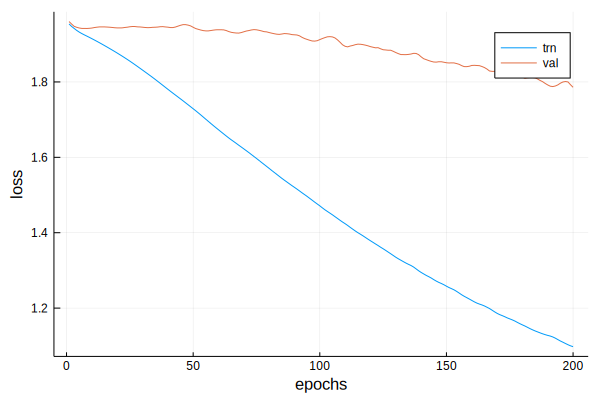

In [58]:
plot(iters, [trnloss, vallos] , xlim=(1:3),labels=[:trn :val :tst], xlabel="epochs", ylabel="loss")

In [59]:
output = model(features)
accuracy(output[:,idx_train], labels_decoded[idx_train])

0.9857142857142858

In [60]:
accuracy(output[:,idx_test], labels_decoded[idx_test])

0.644

In [61]:
png("cora")

In [45]:
#####################################################################################################################

In [62]:
adj, features, labels, idx_train, idx_val, idx_test = load_dataset("citeseer")

(
  [1   ,    1]  =  0.5
  [629 ,    1]  =  0.5
  [2   ,    2]  =  0.166667
  [159 ,    2]  =  0.204124
  [487 ,    2]  =  0.117851
  [1098,    2]  =  0.0912871
  [2920,    2]  =  0.136083
  [2934,    2]  =  0.204124
  [3   ,    3]  =  0.5
  [3286,    3]  =  0.5
  [4   ,    4]  =  0.333333
  [1432,    4]  =  0.288675
  ⋮
  [3323, 3323]  =  0.5
  [3324, 3323]  =  0.5
  [3323, 3324]  =  0.5
  [3324, 3324]  =  0.5
  [132 , 3325]  =  0.25
  [269 , 3325]  =  0.223607
  [2821, 3325]  =  0.223607
  [3325, 3325]  =  0.25
  [1644, 3326]  =  0.5
  [3326, 3326]  =  0.5
  [34  , 3327]  =  0.288675
  [3327, 3327]  =  0.5, 
  [185 ,    1]  =  0.2
  [258 ,    1]  =  0.05
  [363 ,    1]  =  0.0769231
  [561 ,    1]  =  0.0285714
  [566 ,    1]  =  0.00438596
  [598 ,    1]  =  0.0196078
  [601 ,    1]  =  0.00689655
  [602 ,    1]  =  0.0015949
  [638 ,    1]  =  0.00574713
  [730 ,    1]  =  0.0015361
  [806 ,    1]  =  0.00255102
  [817 ,    1]  =  0.00240964
  ⋮
  [1542, 3327]  =  0.00680272
  [161

In [63]:
model = GCN(size(features,1),
            arguments.hidden,
            size(labels,2),
            adj,
            arguments.pdrop)

GCN(GCLayer(P(Array{Float64,2}(16,3703)), P(Array{Float32,1}(16)), 
  [1   ,    1]  =  0.5
  [629 ,    1]  =  0.5
  [2   ,    2]  =  0.166667
  [159 ,    2]  =  0.204124
  [487 ,    2]  =  0.117851
  [1098,    2]  =  0.0912871
  [2920,    2]  =  0.136083
  [2934,    2]  =  0.204124
  [3   ,    3]  =  0.5
  [3286,    3]  =  0.5
  [4   ,    4]  =  0.333333
  [1432,    4]  =  0.288675
  ⋮
  [3323, 3323]  =  0.5
  [3324, 3323]  =  0.5
  [3323, 3324]  =  0.5
  [3324, 3324]  =  0.5
  [132 , 3325]  =  0.25
  [269 , 3325]  =  0.223607
  [2821, 3325]  =  0.223607
  [3325, 3325]  =  0.25
  [1644, 3326]  =  0.5
  [3326, 3326]  =  0.5
  [34  , 3327]  =  0.288675
  [3327, 3327]  =  0.5, NNlib.relu), GCLayer(P(Array{Float64,2}(6,16)), P(Array{Float32,1}(6)), 
  [1   ,    1]  =  0.5
  [629 ,    1]  =  0.5
  [2   ,    2]  =  0.166667
  [159 ,    2]  =  0.204124
  [487 ,    2]  =  0.117851
  [1098,    2]  =  0.0912871
  [2920,    2]  =  0.136083
  [2934,    2]  =  0.204124
  [3   ,    3]  =  0.5
  [328

In [64]:
labels_decoded = mapslices(argmax, labels ,dims=2)[:]

3327-element Array{Int64,1}:
 4
 2
 6
 6
 4
 2
 4
 1
 4
 6
 3
 5
 3
 ⋮
 4
 3
 5
 5
 2
 2
 1
 4
 4
 4
 2
 6

In [65]:
data =  minibatch(features, labels_decoded[:], length(labels_decoded))

Data{Tuple{SparseMatrixCSC{Float64,Int64},Array{Int64,1}}}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [4 2 … 2 6], 3327, 3327, false, 1, 1:3327, false, (3703, 3327), (3327,), SparseMatrixCSC{Float64,Int64}, Array{Int64,1})

In [66]:
iters, trnloss, vallos = mytrain!(model, data, arguments.epochs, arguments.lr, arguments.window_size)

[13, 27:44, 128.02s/i] 


(1:13, Any[1.79682, 1.78464, 1.77055, 1.75611, 1.74216, 1.72789, 1.7132, 1.69825, 1.68346, 1.66874, 1.65399, 1.63896, 1.6239], Any[1.79952, 1.79568, 1.79408, 1.79411, 1.79507, 1.79587, 1.79678, 1.79765, 1.79862, 1.80035, 1.80276, 1.80591, 1.80931])

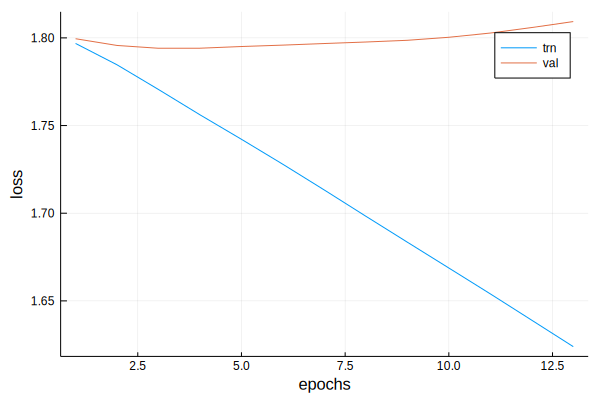

In [67]:
plot(iters, [trnloss, vallos] , xlim=(1:3),labels=[:trn :val :tst], xlabel="epochs", ylabel="loss")

In [68]:
output = model(features)
accuracy(output[:,idx_train], labels_decoded[idx_train])

1.0

In [69]:
accuracy(output[:,idx_test], labels_decoded[idx_test])

0.516

In [70]:
png("citeseer")

In [ ]:
#####################################################################################################################

In [73]:
adj, features, labels, idx_train, idx_val, idx_test = load_dataset("pubmed")

(
  [1    ,     1]  =  0.166667
  [1379 ,     1]  =  0.0671156
  [1545 ,     1]  =  0.0680414
  [6093 ,     1]  =  0.0816497
  [7637 ,     1]  =  0.0870388
  [14443,     1]  =  0.0890871
  [2    ,     2]  =  0.25
  [2944 ,     2]  =  0.138675
  [8360 ,     2]  =  0.111803
  [10200,     2]  =  0.223607
  [3    ,     3]  =  0.25
  [10472,     3]  =  0.144338
  ⋮
  [11821, 19712]  =  0.162221
  [19712, 19712]  =  0.5
  [2362 , 19713]  =  0.0640184
  [19713, 19713]  =  0.5
  [12205, 19714]  =  0.235702
  [19714, 19714]  =  0.5
  [12279, 19715]  =  0.166667
  [19715, 19715]  =  0.5
  [4285 , 19716]  =  0.196116
  [19716, 19716]  =  0.5
  [16031, 19717]  =  0.25
  [19717, 19717]  =  0.5, 
  [8    ,     1]  =  4.11576e-5
  [12   ,     1]  =  0.000618177
  [14   ,     1]  =  8.95405e-5
  [15   ,     1]  =  0.000212583
  [17   ,     1]  =  9.03829e-5
  [19   ,     1]  =  8.64962e-5
  [20   ,     1]  =  0.000538449
  [23   ,     1]  =  0.000109515
  [30   ,     1]  =  0.000122153
  [33   ,     1

In [74]:
model = GCN(size(features,1),
            arguments.hidden,
            size(labels,2),
            adj,
            arguments.pdrop)

GCN(GCLayer(P(Array{Float64,2}(16,500)), P(Array{Float32,1}(16)), 
  [1    ,     1]  =  0.166667
  [1379 ,     1]  =  0.0671156
  [1545 ,     1]  =  0.0680414
  [6093 ,     1]  =  0.0816497
  [7637 ,     1]  =  0.0870388
  [14443,     1]  =  0.0890871
  [2    ,     2]  =  0.25
  [2944 ,     2]  =  0.138675
  [8360 ,     2]  =  0.111803
  [10200,     2]  =  0.223607
  [3    ,     3]  =  0.25
  [10472,     3]  =  0.144338
  ⋮
  [11821, 19712]  =  0.162221
  [19712, 19712]  =  0.5
  [2362 , 19713]  =  0.0640184
  [19713, 19713]  =  0.5
  [12205, 19714]  =  0.235702
  [19714, 19714]  =  0.5
  [12279, 19715]  =  0.166667
  [19715, 19715]  =  0.5
  [4285 , 19716]  =  0.196116
  [19716, 19716]  =  0.5
  [16031, 19717]  =  0.25
  [19717, 19717]  =  0.5, NNlib.relu), GCLayer(P(Array{Float64,2}(3,16)), P(Array{Float32,1}(3)), 
  [1    ,     1]  =  0.166667
  [1379 ,     1]  =  0.0671156
  [1545 ,     1]  =  0.0680414
  [6093 ,     1]  =  0.0816497
  [7637 ,     1]  =  0.0870388
  [14443,     1] 

In [75]:
labels_decoded = mapslices(argmax, labels ,dims=2)[:]

19717-element Array{Int64,1}:
 2
 2
 1
 3
 2
 3
 3
 2
 3
 2
 3
 3
 3
 ⋮
 1
 1
 3
 3
 3
 3
 1
 3
 1
 3
 1
 3

In [76]:
output = model(features)
accuracy(output[:,idx_val], labels_decoded[idx_val])

0.226

In [77]:
data =  minibatch(features, labels_decoded[:], length(labels_decoded))

Data{Tuple{SparseMatrixCSC{Float32,Int64},Array{Int64,1}}}(Float32[0.0 0.0 … 0.000312837 0.0; 0.0 0.0 … 0.0 0.000428267; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [2 2 … 1 3], 19717, 19717, false, 1, 1:19717, false, (500, 19717), (19717,), SparseMatrixCSC{Float32,Int64}, Array{Int64,1})

In [78]:
iters, trnloss, vallos = mytrain!(model, data, arguments.epochs, arguments.lr, arguments.window_size)

InterruptException: InterruptException:

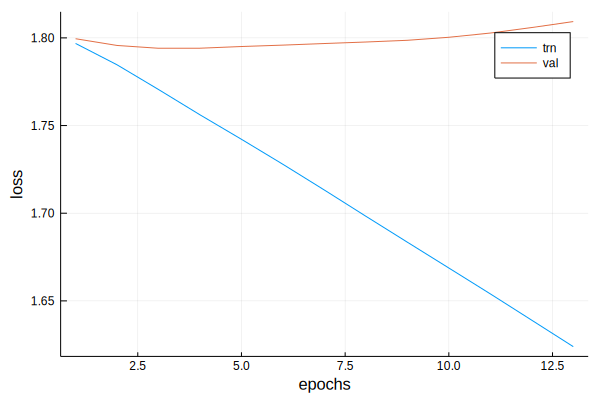

In [79]:
plot(iters, [trnloss, vallos] , xlim=(1:3),labels=[:trn :val :tst], xlabel="epochs", ylabel="loss")

In [80]:
output = model(features)
accuracy(output[:,idx_train], labels_decoded[idx_train])

0.31666666666666665

In [81]:
accuracy(output[:,idx_test], labels_decoded[idx_test])

0.303

In [82]:
png("pubmed")